# 1. The key features of TensorFlow
## Basic imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1.1. Creating a graph in TensorFlow v1.x
- In earlier version of the TensorFlow low-level API, this graph had to be explicitly declared
- In TensorFlow v1.x, a session is an environment in which the operations and tensors of a graph can be executed
- After launching a graph in a TensorFlow session, we can execute its nodes, that is, evaluate its tensors or execute its operators
- When evaluating a specific tensor in the graph, TensorFlow has to execute all the preceding nodes in the graph until it reaches the given node of interest

In [2]:
g = tf.Graph()
with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    z = 2*(a - b) + c
    
with tf.compat.v1.Session(graph=g) as sess:
    print('Result: z =', sess.run(z))
    print('Result: z =', z.eval())

Result: z = 1
Result: z = 1


## 1.2. Migrating a graph to TensorFlow v2
- TensorFlow v2 uses dynamic (as oposed to static) graphs by default (this is also called eager execution in TensorFlow), which allows us to evaluate an operation on the fly

In [3]:
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.constant(3, name='c')

z = 2*(a - b) + c
tf.print('Result: z =', z)

Result: z = 1


## 2.1. Loading input data into a model: TensorFlow v1.x style
- When using the TensorFlow v1.x low-level API, we had to create placeholder variables for providing input data to a model

In [4]:
g = tf.Graph()
with g.as_default():
    a = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_a')
    b = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_b')
    c = tf.compat.v1.placeholder(shape=None, dtype=tf.int32, name='tf_c')
    z = 2*(a - b) + c
    
with tf.compat.v1.Session(graph=g) as sess:
    feed_dict = {a:1, b:2, c:3}
    print('Result: z =', sess.run(z, feed_dict=feed_dict))

Result: z = 1


## 2.2. Loading input data into a model: TensorFlow v2 style
- In TensorFlow v2, all this can simply be done by defining a regular Python function with a, b, and c as its input arguments

In [6]:
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

tf.print('Scalar Inputs:', compute_z(1, 2, 3))
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 2 Inputs:', compute_z([[1]], [[2]], [[3]]))

Scalar Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


## 3. Improving computational performance with function decorators
- TensorFlow v2 provides a tool called AutoGraph that can automatically transform Python code into TensorFlow's graph code for faster execution
- In addition, TensorFlow provides a simple mechanism for compiling a normal Python function to a static TensorFlow graph in order to make the computations more efficient

In [7]:
@tf.function
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

tf.print('Scalar Inputs:', compute_z(1, 2, 3))
tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 2 Inputs:', compute_z([[1]], [[2]], [[3]]))

Scalar Inputs: 1
Rank 1 Inputs: [1]
Rank 2 Inputs: [[1]]


- If we want to want to limit the way a function can be called, we can specify its imput signature via a tuple of tf.TensorSpec objects when defining the function
- Redefine the previous function, compute_z, and specify that only ran 1 tensors of type tf.int32 are allowed

In [8]:
@tf.function(input_signature=(tf.TensorSpec(shape=[None], dtype=tf.int32),
                              tf.TensorSpec(shape=[None], dtype=tf.int32),
                              tf.TensorSpec(shape=[None], dtype=tf.int32),))
def compute_z(a, b, c):
    r1 = tf.subtract(a, b)
    r2 = tf.multiply(2, r1)
    z = tf.add(r2, c)
    return z

tf.print('Rank 1 Inputs:', compute_z([1], [2], [3]))
tf.print('Rank 1 Inputs:', compute_z([1, 2], [2, 4], [3, 6]))

Rank 1 Inputs: [1]
Rank 1 Inputs: [1 2]


```python
## we expect this to result in an error
tf.print('Rank 2 Inputs:', compute_z([[1], [2]], [[2], [4]], [[3], [6]]))


## >> Error:
#ValueError: Python inputs incompatible with input_signature: 
#inputs (([[1], [2]], [[2], [4]], [[3], [6]])), input_signature 
#((TensorSpec(shape=(None,), dtype=tf.int32, name=None), 
#  TensorSpec(shape=(None,), dtype=tf.int32, name=None), 
#  TensorSpec(shape=(None,), dtype=tf.int32, name=None)))
```

## 4. TensorFlow Variable objects for storing and updating model parameters
- In the context of TensorFlow, a Variable is a special Tensor object that allows us to store and update the parameters of our models during training

In [9]:
a = tf.Variable(initial_value=3.14, name='var_a')
b = tf.Variable(initial_value=[1, 2, 3], name='var_b')
c = tf.Variable(initial_value=[True, False], dtype=tf.bool)
d = tf.Variable(initial_value=['abc'], dtype=tf.string)
print(a)
print(b)
print(c)
print(d)

<tf.Variable 'var_a:0' shape=() dtype=float32, numpy=3.14>
<tf.Variable 'var_b:0' shape=(3,) dtype=int32, numpy=array([1, 2, 3])>
<tf.Variable 'Variable:0' shape=(2,) dtype=bool, numpy=array([ True, False])>
<tf.Variable 'Variable:0' shape=(1,) dtype=string, numpy=array([b'abc'], dtype=object)>


### 1. Trainable and untrainable variables
- Variables have an attribute called trainable, which, by default, is set to True

In [10]:
a.trainable

True

- We can define a non-trainable Variable as follows

In [11]:
w = tf.Variable([1, 2, 3], trainable=False)

print(w.trainable)

False


### 2. Modifying the values of variables
- The values of a Variable can be efficiently modified by running some operations such as .assign(), .assign_add() and related methods

In [12]:
print(w.assign([3, 1, 4], read_value=True))
w.assign_add([2, -1, 2], read_value=False)

print(w.value())

<tf.Variable 'UnreadVariable' shape=(3,) dtype=int32, numpy=array([3, 1, 4])>
tf.Tensor([5 0 6], shape=(3,), dtype=int32)


### 3. Initializing variables with random values for learning
- For NN models intializing model parameters with random weights is necessary to break the symmetry during backpropagation - otherwise, a multilayer NN would be no more useful than a single-layer NN like logistic regression
- We can create a Variable with Glorot initialization, which is a classic random initialization scheme

In [13]:
tf.random.set_seed(1)
init = tf.keras.initializers.GlorotNormal()

tf.print(init(shape=(3,)))

[-0.722795904 1.01456821 0.251808226]


In [14]:
v = tf.Variable(init(shape=(2, 3)))
tf.print(v)

[[0.28982234 -0.782292783 -0.0453658961]
 [0.960991383 -0.120003454 0.708528221]]


### 4. Putting variables in the context of a more practical use case
- We can define a Variable inside the base tf.Module class and access all of them using attributes made available by subclassing the tf.Module class

In [15]:
class MyModule(tf.Module):
    def __init__(self):
        init = tf.keras.initializers.GlorotNormal()
        self.w1 = tf.Variable(init(shape=(2, 3)), trainable=True)
        self.w2 = tf.Variable(init(shape=(1, 2)), trainable=False)
                
m = MyModule()
print('All module variables: ', [v.shape for v in m.variables])
print('Trainable variable:   ', [v.shape for v in
                                 m.trainable_variables])

All module variables:  [TensorShape([2, 3]), TensorShape([1, 2])]
Trainable variable:    [TensorShape([2, 3])]


### 5. Variables with tf.function
- TensorFlow does not allow the creation of a Variable inside a decorated function and, as a result, the following code will raise an error (for reason refer to the book)
```python

## this will produce an error
## ==> you cannot create a varibale inside a
##     decorated function

@tf.function
def f(x):
    w = tf.Variable([1, 2, 3])

f([1])

## ==> results in error
## ValueError: tf.function-decorated function tried to create variables on non-first call.

```
- One way to avoid this problem is to define the Variable outside of the decorated function and use it inside the function

In [ ]:
import tensorflow as tf

tf.random.set_seed(1)
w = tf.Variable(tf.random.uniform((3, 3)))

@tf.function
def compute_z(x):    
    return tf.matmul(w, x)

x = tf.constant([[1], [2], [3]], dtype=tf.float32)
tf.print(compute_z(x))

## 3. Computing gradients via automatic differentiation and GradientTape
- TensorFlow supports automatic differentiation, which can be thought of as an implementation of the chain rule for computing gradients of nested fucntions
- When we define a series of operations that results in some output or even intermediate tensors, TensorFlow provides a context for calculating gradients of these computed tensors with respect to its dependent nodes in the computation graph
- In order to compute these gradients, we have to "record" the computations via tf.GradientTape
### 1. Computing the gradients of the loss with respect to trainable variables
- We place the computation of z and the loss withing the tf.GradientTape context

In [16]:
import tensorflow as tf

w = tf.Variable(1.0)
b = tf.Variable(0.5)
print(w.trainable, b.trainable)

x = tf.convert_to_tensor([1.4])
y = tf.convert_to_tensor([2.1])

with tf.GradientTape() as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)

tf.print('dL/dw : ', dloss_dw)

True True
dL/dw :  -0.559999764


### 2. Verify the computed gradient
- Since this is a very simple example, we can obtain the derivatives symbolically

In [17]:
tf.print(2*x * ((w*x + b) - y))

[-0.559999764]


### 3. Computing gradients with respect to non-trainable tensors
- tf.GradientTape automatically supports the gradients for trainable variables
- However, for non-trainable variables and other Tensor objects, we need to add an additional modifications to the GradientTape called tape.watch() to monitor those as well

In [18]:
with tf.GradientTape() as tape:
    tape.watch(x)
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.square(y - z)

dloss_dx = tape.gradient(loss, x)

tf.print('dL/dx:', dloss_dx)

dL/dx: [-0.399999857]


### 4. Verify the computed gradient

In [19]:
tf.print(2*w * ((w*x + b) - y))

[-0.399999857]


### 5. Keeping resources for multiple gradient computations
- When we monitor the computations in the context of th.GradientTape, by default, the tape will keep the resources only for a single gradient computation
- If we want to compute more than one gradient, we need to make the tape persistent

In [20]:
with tf.GradientTape(persistent=True) as tape:
    z = tf.add(tf.multiply(w, x), b)
    loss = tf.reduce_sum(tf.square(y - z))

dloss_dw = tape.gradient(loss, w)
dloss_db = tape.gradient(loss, b)

tf.print('dL/dw:', dloss_dw)
tf.print('dL/db:', dloss_db)

dL/dw: -0.559999764
dL/db: -0.399999857


### 6. Updating variables
- If we are computing gradients of a loss term with respect to the parameters of a model, we can define an optimizer and apply the gradients to optimize the model parameters using the tf.keras API

In [21]:
optimizer = tf.keras.optimizers.SGD()

optimizer.apply_gradients(zip([dloss_dw, dloss_db], [w, b]))

tf.print('Updated w:', w)
tf.print('Updated bias:', b)

Updated w: 1.0056
Updated bias: 0.504


## 4. Simplifying implementations of common architectures via the Keras API 
### 1. Building a model with two densely (fully) connected layers

In [22]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))

## late variable creation
model.build(input_shape=(None, 4))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  80        
_________________________________________________________________
dense_1 (Dense)              multiple                  544       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


### 2. Printing variables (or model parameters) of the model

In [24]:
for v in model.variables:
    print('{:20s}'.format(v.name), v.trainable, v.shape)

dense/kernel:0       True (4, 16)
dense/bias:0         True (16,)
dense_1/kernel:0     True (16, 32)
dense_1/bias:0       True (32,)


### 3.1 Configuring layers
 * Keras Initializers `tf.keras.initializers`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/initializers  
 * Keras Regularizers `tf.keras.regularizers`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/regularizers  
 * Activations `tf.keras.activations`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/activations  
### 3.2. Configure the first layer by specifying initializers for the kernel and bias variables and the second layer by specifying an L1 regularizer for the kernel (weight matrix)

In [25]:
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=16, 
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.Constant(2.0)
    ))

model.add(
    tf.keras.layers.Dense(
        units=32, 
        activation=tf.keras.activations.sigmoid,
        kernel_regularizer=tf.keras.regularizers.l1
    ))

model.build(input_shape=(None, 4))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  80        
_________________________________________________________________
dense_3 (Dense)              multiple                  544       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


### 4.1 Compiling a model
 * Keras Optimizers `tf.keras.optimizers`:  https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
 * Keras Loss Functins `tf.keras.losses`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses
 * Keras Metrics `tf.keras.metrics`: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics

### 4.2 Compile the model using the SGD optimizer, cross-entropy loss for binary classification, and a specific list of metrics, including accuracy, precision, and recall
- In addition to configuring the individual layers, we can also configure the model when we compile it
 - We can specify the type of optimizer and the loss function for training, as well as which metrics to use for reporting the performance on the training, validation, and test datasets

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.Accuracy(), 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall(),])

## 5. Solving an XOR classification problem
### 1. Generate the data and split it into the training and validation datasets

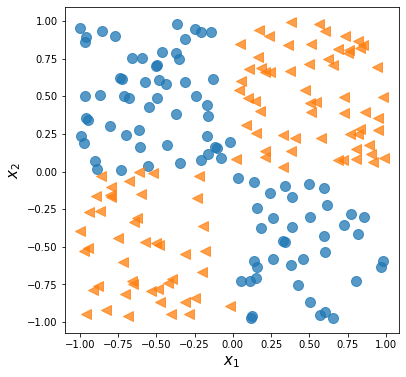

In [28]:
tf.random.set_seed(1)
np.random.seed(1)

x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

x_train = x[:100, :]
y_train = y[:100]
x_valid = x[100:, :]
y_valid = y[100:]

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

### 2. Start with a simple model
- In general, models with higher number of layers and neurons have larger capacity, meaning that they can readily approximate more complex fucntion
- But such models are usually harder to train and are prone to overfitting
- In practice, it is always a good idea to start with a simple model as a base line, for example, a single-layer NN like logistic regression

In [29]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, 
                                input_shape=(2,), 
                                activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


### 3. Compile the model

In [30]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

### 4. Train the model
- Training the model for 200 epochs using a batch size of 2

In [31]:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

### 5. Plot the training performance along with the decision region bias
- A simple model with no hidden layer can only derive a linear decision boundary, which is unable to solve the XOR problem

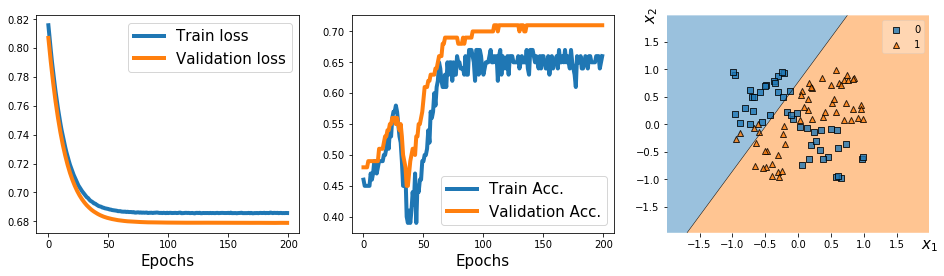

In [32]:
from mlxtend.plotting import plot_decision_regions

history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 6.1. Train a feedforward NN with 1 hidden layer

In [34]:
tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

history = hist.history

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


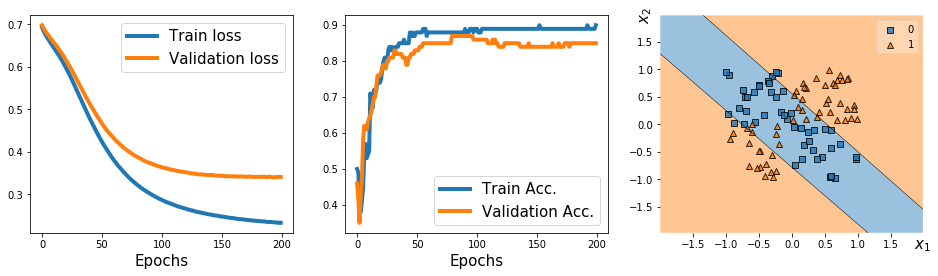

In [35]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 6.2. Train a feedforward NN with 2 hidden layers

In [36]:
tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

history = hist.history

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


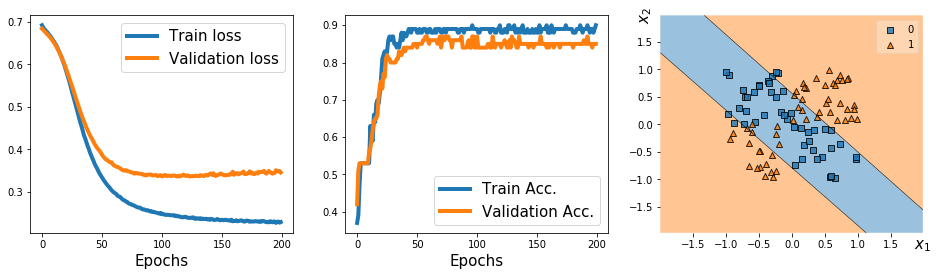

In [37]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 6.3. Train a feedforward NN with 3 hidden layers

In [38]:
tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

history = hist.history

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


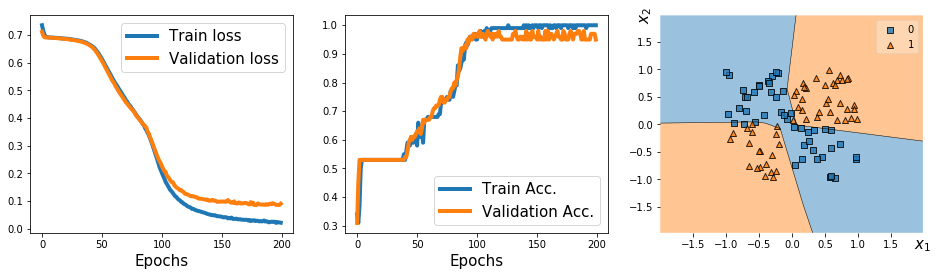

In [39]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### 6.4. Train a feedforward NN with 4 hidden layers

In [40]:
tf.random.set_seed(1)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=4, input_shape=(2,), activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

history = hist.history

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


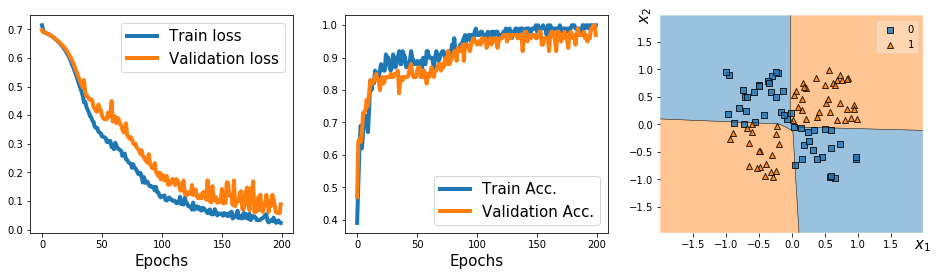

In [41]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## 6. Making model building more flexible with Keras' functional API
### 1. Implement the same architecture that we built using the objected-oriented (Sequential) approach in the previous section
- In this approach we specify inputs to all layers, except for the input layer

In [42]:
tf.random.set_seed(1)

## input layer:
inputs = tf.keras.Input(shape=(2,))

## hidden layers
h1 = tf.keras.layers.Dense(units=4, activation='relu')(inputs)
h2 = tf.keras.layers.Dense(units=4, activation='relu')(h1)
h3 = tf.keras.layers.Dense(units=4, activation='relu')(h2)

## output:
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(h3)

## construct a model:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


### 2. Compile and train the model
- As we can see, the results are identical to the Sequential implementation with 3 hidden layers

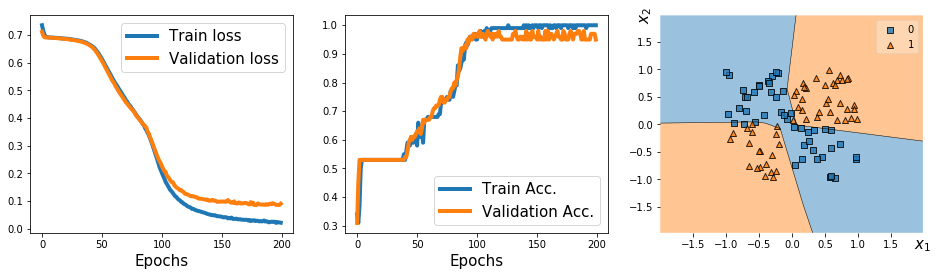

In [43]:
## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

## Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## 7. Implementing models based on Keras' Model class
- In this approach, we create a new class derived from tf.keras.Model
- In the constructor function, __init__(), we define the layers as attributes of the class so that they can be accessed via the self reference attribute
- Then, in the call() method, we specify how these layers are to be used in the forward pass of the NN

### 1. Define a new class that implements the previous model

In [44]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.hidden_1 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_2 = tf.keras.layers.Dense(units=4, activation='relu')
        self.hidden_3 = tf.keras.layers.Dense(units=4, activation='relu')
        self.output_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')
        
    def call(self, inputs):
        h = self.hidden_1(inputs)
        h = self.hidden_2(h)
        h = self.hidden_3(h)
        return self.output_layer(h)
    
tf.random.set_seed(1)

## testing:
model = MyModel()
model.build(input_shape=(None, 2))

model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             multiple                  12        
_________________________________________________________________
dense_28 (Dense)             multiple                  20        
_________________________________________________________________
dense_29 (Dense)             multiple                  20        
_________________________________________________________________
dense_30 (Dense)             multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


### 2. Compile and train the model

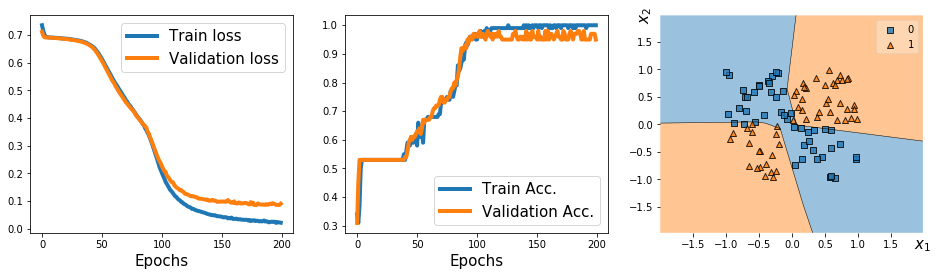

In [45]:
## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, verbose=0)

## Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

## 8. Writing custom Keras layers
### 1. Define a new custom layer

In [48]:
class NoisyLinear(tf.keras.layers.Layer):
    def __init__(self, output_dim, noise_stddev=0.1, **kwargs):
        self.output_dim = output_dim
        self.noise_stddev = noise_stddev
        super(NoisyLinear, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w = self.add_weight(name='weights',
                                 shape=(input_shape[1], self.output_dim),
                                 initializer='random_normal',
                                 trainable=True)
        
        self.b = self.add_weight(shape=(self.output_dim,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs, training=False):
        if training:
            batch = tf.shape(inputs)[0]
            dim = tf.shape(inputs)[1]
            noise = tf.random.normal(shape=(batch, dim),
                                     mean=0.0,
                                     stddev=self.noise_stddev)

            noisy_inputs = tf.add(inputs, noise)
        else:
            noisy_inputs = inputs
        z = tf.matmul(noisy_inputs, self.w) + self.b
        return tf.keras.activations.relu(z)
    
    def get_config(self):
        config = super(NoisyLinear, self).get_config()
        config.update({'output_dim': self.output_dim,
                       'noise_stddev': self.noise_stddev})
        return config

### 2. Test the custom layer on some tensors

In [52]:
tf.random.set_seed(1)

noisy_layer = NoisyLinear(4)
noisy_layer.build(input_shape=(None, 4))

x = tf.zeros(shape=(1, 4))
tf.print(noisy_layer(x, training=True))

## re-building from config:
config = noisy_layer.get_config()
new_layer = NoisyLinear.from_config(config)
tf.print(new_layer(x, training=True))

[[0 0.00821428 0 0]]
[[0 0.0108502861 0 0]]


### 3. Use the NoisyLinear layer as the first hidden layer in otherwise the same architecture as befor

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noisy_linear_6 (NoisyLinear) multiple                  12        
_________________________________________________________________
dense_31 (Dense)             multiple                  20        
_________________________________________________________________
dense_32 (Dense)             multiple                  20        
_________________________________________________________________
dense_33 (Dense)             multiple                  5         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


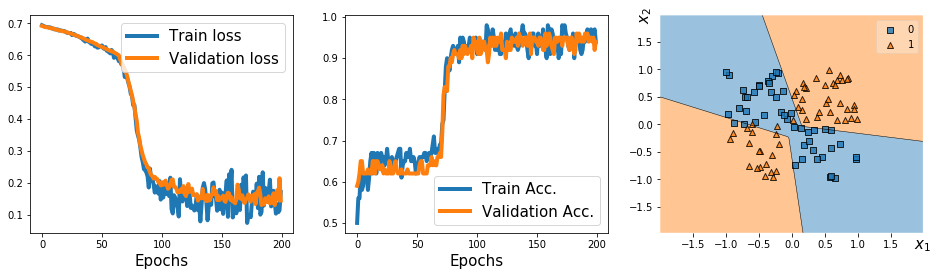

In [53]:
tf.random.set_seed(1)

model = tf.keras.Sequential([
    NoisyLinear(4, noise_stddev=0.1),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=4, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')])

model.build(input_shape=(None, 2))
model.summary()

## compile:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

## train:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_valid, y_valid), 
                 epochs=200, batch_size=2, 
                 verbose=0)

## Plotting
history = hist.history

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=4)
plt.plot(history['val_loss'], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history['binary_accuracy'], lw=4)
plt.plot(history['val_binary_accuracy'], lw=4)
plt.legend(['Train Acc.', 'Validation Acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid, y=y_valid.astype(np.integer),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()